In [1]:
import pandas as pd
import glob
import re
import datetime as dt

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt

import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn import feature_selection as f_select
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import RFECV

%matplotlib inline

/Users/bauer/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path = '../../local_files/scrapy_project/tutorial'
allFiles = glob.glob(path + "/*.csv")

In [3]:
def getFiles(filename):
    df = pd.read_csv(filename, thousands=",")
    col = str(filename.split('/')[-1].replace('_movie.csv',""))
    df[col] = 1
    return df

In [4]:
df_all = getFiles(allFiles[0])
for file in allFiles[1:]:
    current_df = getFiles(file)
    df_all = pd.merge(df_all,current_df,how="outer", on=['title','user_score','meta_score','gross','runtime','genre','year','rating','director','votes','popularity','actor1','actor2','actor3','actor4','description'])

df_all['year']=df_all.year.str.replace(r'[^0-9]', '')
df_all['runtime']=df_all.runtime.str.replace(r'[^0-9]', '')
df_all['genre']=df_all.genre.str.replace(r'[\n]', '')
df_all['description']=df_all.description.str.replace(r'[\n]', '')
df_all['runtime']=df_all['runtime'].convert_objects(convert_numeric=True)
df_all['user_score']=df_all['user_score']*10

/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [5]:
#df_all['title'].sort_values(ascending=False)
#len(df_all[df_all.duplicated('title')==False])

In [6]:
bi_vars = ['african_american','african_american_woman', 'bisexual', 'cat', 'crying', 'cult', 'dog',\
           'female_nudity', 'gay', 'independent', 'lesbian', 'male_nudity','police', 'racism',\
           'sequel', 'transgender']

for i in bi_vars:
    df_all[i].fillna(0, inplace=True)
df_all.iloc[:2,:18]

df_all['lgbt']= np.where((df_all['gay']+df_all['lesbian']+df_all['bisexual']+df_all['transgender'])>0,1,0)

In [7]:
df_full = df_all.dropna()
df_full['year']=list(df_full['year'].apply(lambda x: int(x)))
df_full.iloc[:2,:18]

/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,title,votes,director,year,popularity,actor2,actor3,meta_score,actor1,description,user_score,rating,runtime,actor4,gross,genre,african_american,african_american_woman
0,La La Land,92976.0,Damien Chazelle,2016,1.0,Emma Stone,Rosemarie DeWitt,93.0,Ryan Gosling,A jazz pianist falls for an aspiring actress i...,87.0,PG-13,128.0,J.K. Simmons,89680497.0,"Comedy, Drama, Musical",1.0,0.0
1,Hidden Figures,12581.0,Theodore Melfi,2016,2.0,Octavia Spencer,Janelle Monáe,74.0,Taraji P. Henson,Based on a true story. A team of African-Ameri...,80.0,PG,127.0,Kevin Costner,84238751.0,"Biography, Drama, History",1.0,0.0


**Import Billboard Data**

In [8]:
bbpath = path = '../../local_files/scrapy_project/tutorial/music'
bbdata = pd.read_csv(bbpath+'/billboard.csv')
bbdata["date_bb"] = pd.to_datetime(bbdata.date_bb , format="%B %d, %Y")
bbdata['last_bb']=bbdata.last_bb.str.replace(r'[\–]', '')
bbdata['title_bb']= bbdata['title_bb'].apply(lambda x: x.split(':')[0])
bbdata["title"]=bbdata["title_bb"]
bbdata = bbdata.drop(["title_bb"], axis=1, errors="ignore")
bbdata.head()

,peak_bb,date_bb,weeks_bb,last_bb,title
0,1,2016-08-27,24,15,Suicide Squad
1,1,2014-08-23,87,120,Guardians Of The Galaxy
2,1,2015-04-25,46,,Furious 7
3,1,2014-01-18,116,181,Frozen
4,1,2015-05-30,31,183,Pitch Perfect 2


In [9]:
len(bbdata),len(df_full)

(650, 10319)

In [10]:
bb_df = pd.merge(bbdata,df_full,on='title',how='left')
bb_df_full = bb_df.dropna()

In [11]:
len(bb_df_full)

531

In [12]:
type(bb_df)

pandas.core.frame.DataFrame

In [13]:
bb_df_full['actor'] = bb_df_full['actor1']+','+bb_df_full['actor2']+','+bb_df_full['actor3']+','+bb_df_full['actor4']
bb_df_full['actor'] = [str.lower(i).strip() for i in bb_df_full['actor']]
bb_df_full['genre'] = [str.lower(i).strip() for i in bb_df_full['genre']]
bb_df_full['director'] = [str.lower(i).strip() for i in bb_df_full['director']]

/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [14]:
#make_dummies 
actors = bb_df_full['actor'].str.get_dummies(sep=',') #srt
genres = bb_df_full['genre'].str.get_dummies(sep=',')
directors =bb_df_full['director'].str.get_dummies(sep=',')

In [15]:
bb_df_full['title'].sort_values(ascending=True)

145    2 Fast 2 Furious
144    2 Fast 2 Furious
146    2 Fast 2 Furious
605     A Knight's Tale
827    About Last Night
828    About Last Night
829    About Last Night
830    About Last Night
750                 Ali
751                 Ali
752                 Ali
609       Almost Famous
608       Almost Famous
672        American Pie
671        American Pie
673        American Pie
174      American Pie 2
177      American Pie 2
176      American Pie 2
175      American Pie 2
395    American Wedding
396    American Wedding
397    American Wedding
393    American Wedding
394    American Wedding
819        Animal House
821        Animal House
820        Animal House
257               Annie
256               Annie
             ...       
371        Transformers
655        Transformers
370        Transformers
168        Transformers
169        Transformers
773            Twilight
17             Twilight
457             Twister
714          Underworld
348     Valentine's Day
350     Valentin

In [16]:
all_bi = pd.DataFrame(pd.concat([actors,genres,directors]))
#all_bi.columns = [str.lower(column).strip() for column in all_bi.columns]
test = pd.DataFrame.sum(all_bi)
test.sort_values(ascending=True)

#df_to_process = pd.concat([metrics.reset_index(drop=True), genres], axis=1)#actors, directors
#df_to_process = df_to_process.dropna()
#[list1[i] for i in range(len(list1)) if list2[i]>5.0)]

nancy meyers                 1.0
shawn ashmore                1.0
shannyn sossamon             1.0
redman                       1.0
reginald hudlin              1.0
shane brolly                 1.0
renee jewell                 1.0
seth macfarlane              1.0
john marley                  1.0
sean nelson                  1.0
dj pooh                      1.0
sean mcnamara                1.0
rhys ifans                   1.0
john lasseter                1.0
doug mchenry                 1.0
dr. dre                      1.0
scott speedman               1.0
ed ackerman                  1.0
joel schumacher              1.0
sandro dori                  1.0
sanaa lathan                 1.0
edward james olmos           1.0
richard hunt                 1.0
elayn j. taylor              1.0
samantha mathis              1.0
joe ranft                    1.0
joe manganiello              1.0
emma bell                    1.0
emma stone                   1.0
eric dane                    1.0
          

**Inflation Data**

In [17]:
inflation_raw = pd.read_csv('inflation1.csv')
twentysixteen = inflation_raw[inflation_raw['Year']==2016]
twentysixteen = float(twentysixteen['Avg'])
inflation_raw['twentysixteen'] = twentysixteen
inflation_raw.columns = ['year', 'Avg','twentysixteen']
inflation_raw.columns

Index(['year', 'Avg', 'twentysixteen'], dtype='object')

In [18]:
len(inflation_raw)

104

In [19]:
bb_df_full = pd.merge(bb_df_full,inflation_raw,on='year',how='left')
bb_df_full['adj_gross'] = bb_df_full['gross']*bb_df_full['twentysixteen']/bb_df_full['Avg']
len(bb_df_full)

531

In [20]:
metrics = bb_df_full[['meta_score','user_score','runtime','gross','votes','peak_bb','weeks_bb','african_american',\
                      'african_american_woman', 'bisexual', 'cat', 'crying', 'cult', 'dog','female_nudity', 'gay',\
                      'independent', 'lesbian', 'male_nudity','police', 'racism','sequel', 'transgender','lgbt']]

df_to_process = pd.concat([metrics.reset_index(drop=True), genres], axis=1)#actors, directors
df_to_process = df_to_process.dropna()

normed = pd.DataFrame(preprocessing.normalize(df_to_process, axis=0, norm='max'))
normed.columns = df_to_process.columns
normed.head(2)

,meta_score,user_score,runtime,gross,votes,peak_bb,weeks_bb,african_american,african_american_woman,bisexual,...,animation,biography,comedy,crime,drama,horror,musical,mystery,romance,thriller
0,0.40,0.695652,0.634021,0.49345,0.244806,0.011111,0.149068,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.43,0.673913,0.479381,0.00037,0.039606,0.011111,0.720497,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Check Normalization**

In [21]:
X = normed.drop(["gross"], axis=1, errors="ignore")
y = normed['gross']

print(X.std()[1])
X.mean()[1]

0.100748301142


0.74620659468923323

In [22]:
with open('normalized_bb_imdb.pkl', 'wb') as picklefile:
    pickle.dump(normed, picklefile)

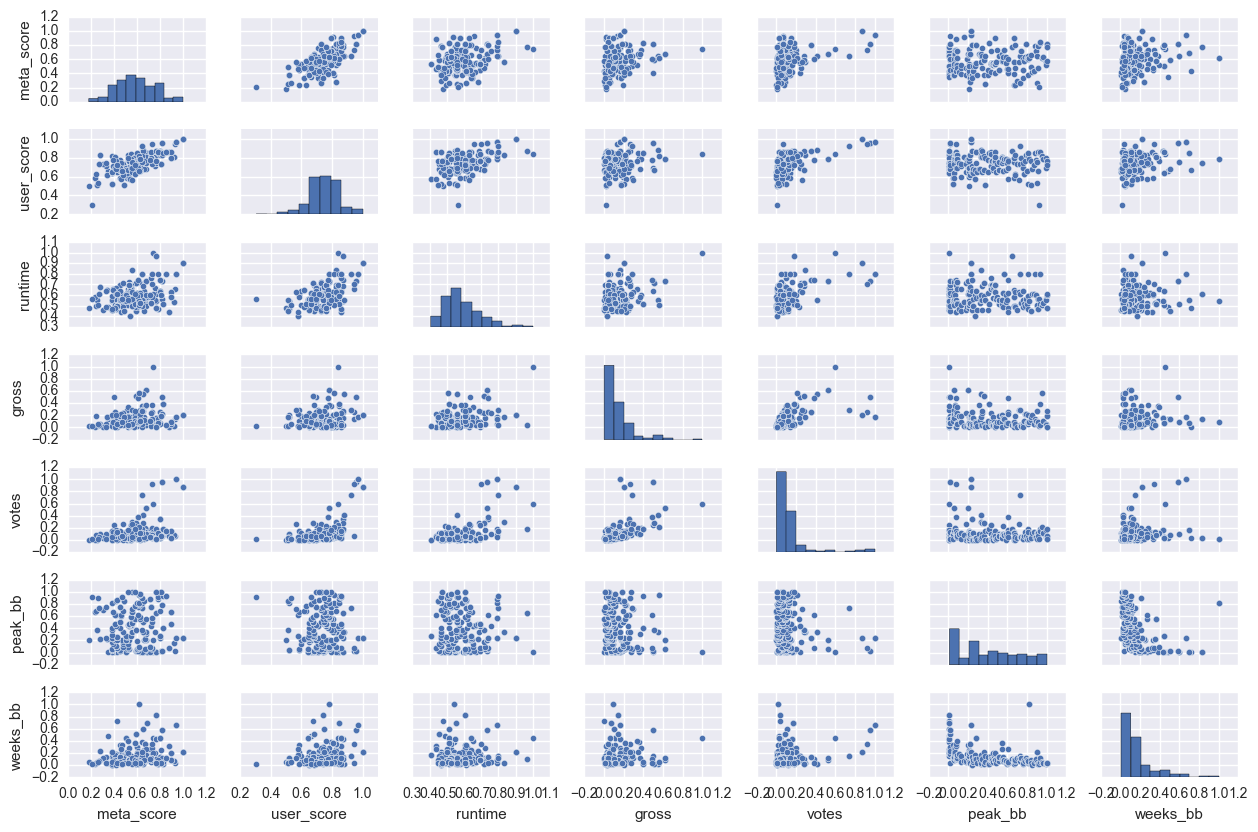

In [23]:
pair_normed = normed[['meta_score','user_score','runtime','gross','votes','peak_bb','weeks_bb']]
sns.pairplot(pair_normed, size = 1.2, aspect=1.5)

In [24]:
#test = normed[normed.sum(axis=1) > 1]
#len(test.columns),len(test.index)
test = pd.DataFrame.sum(normed)
test.sort_values(ascending=False)

user_score                222.369565
runtime                   175.917526
meta_score                175.670000
 drama                    123.000000
peak_bb                   118.155556
action                    103.000000
comedy                     74.000000
 romance                   57.000000
weeks_bb                   52.453416
drama                      51.000000
 crime                     48.000000
 adventure                 47.000000
cult                       45.000000
 comedy                    44.000000
gross                      42.098868
votes                      40.042835
 thriller                  39.000000
police                     38.000000
female_nudity              37.000000
 music                     35.000000
crime                      30.000000
african_american           30.000000
dog                        27.000000
 sci-fi                    26.000000
lgbt                       21.000000
male_nudity                19.000000
sequel                     19.000000
i

In [25]:
#[list1[i] for i in range(len(list1)) if list2[i]>5.0)] # list1 is the column names or index of thing list2 is the sums

## Modeling
**Stepwise OLS**

In [26]:
#Reduce amount of factors
X = normed[['meta_score','user_score','runtime','votes','peak_bb','weeks_bb','african_american',\
                      'african_american_woman', 'bisexual', 'cat', 'crying', 'cult', 'dog','female_nudity', 'gay',\
                      'independent', 'lesbian', 'male_nudity','police', 'racism','sequel', 'transgender','lgbt']]

In [27]:
X.iloc[:2,:18]

,meta_score,user_score,runtime,votes,peak_bb,weeks_bb,african_american,african_american_woman,bisexual,cat,crying,cult,dog,female_nudity,gay,independent,lesbian,male_nudity
0,0.40,0.695652,0.634021,0.244806,0.011111,0.149068,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.43,0.673913,0.479381,0.039606,0.011111,0.720497,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
y.head()

0    0.493450
1    0.000370
2    0.278494
3    0.026576
4    0.026576
Name: gross, dtype: float64

In [29]:
X.head()

,meta_score,user_score,runtime,votes,peak_bb,weeks_bb,african_american,african_american_woman,bisexual,cat,...,female_nudity,gay,independent,lesbian,male_nudity,police,racism,sequel,transgender,lgbt
0,0.40,0.695652,0.634021,0.244806,0.011111,0.149068,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.43,0.673913,0.479381,0.039606,0.011111,0.720497,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.63,0.706522,0.592784,0.075649,0.011111,0.192547,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.38,0.652174,0.463918,0.004792,0.011111,0.211180,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.38,0.652174,0.463918,0.004792,0.011111,0.211180,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
linreg = LinearRegression()
rfe = RFE(estimator=linreg, n_features_to_select=1, step=1)
rfe.fit(X, y)

NameError: name 'RFE' is not defined

In [ ]:
X = normed.drop(["gross"], axis=1, errors="ignore")
y = normed['gross']
rfecv =   RFECV(estimator=linreg, cv=5)
rfecv.fit(X, y)
X_rfecv=rfecv.transform(X)
#print(X_rfecv)

In [ ]:
ranks = pd.DataFrame(rfecv.ranking_)
#df_to_process = pd.concat([metrics.reset_index(drop=True), actors,genres,directors], axis=1)
ranks['col_names']=X.columns
ranks[ranks[0]<=19]

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
kf=KFold(n=len(X),n_folds=2,shuffle=True)

all_scores=[]


# get indices of corresponding train & test
for train,test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
            
    model=sm.OLS(y_train,x_train)
    est=model.fit()
    pvals=est.pvalues.sort_values()
    # we can eliminate features iteratively
    
    for i in range(5):
        ## recalculate pvalue
        pvals=pvals[:-6]
        ## remove 6 features at a time
        feature_keep=pvals.index
        #print(len(feature_keep))
        
        x_train=x_train[feature_keep]
        x_test=x_test[feature_keep]
        model=sm.OLS(y_train,x_train)
        est=model.fit()
        pvals=est.pvalues.sort_values()
        
        
    
    r_2=est.rsquared
    all_scores.append(r_2)
        
np.mean(all_scores)
est.summary()

## SKLearn Feature Selection

In [ ]:
est=LinearRegression()
selector = RFECV(est, step=1, cv=None, scoring=None, verbose=0, n_jobs=1)
selector.fit(X, y)

In [ ]:
best_X = RFECV.transform(X)
best_X.head()

In [ ]:
#filtering features using p-value: 
est=LinearRegression()


sig_columns=[]
pvals=[]

for feature in X.columns:
    #get pval on feature by feature basis
    pval=f_select.f_regression(X[[feature]],y)
    if pval[1][0]<.02: 
        sig_columns.append(feature)
        pvals.append(pval[1][0])
        
X_trans=X[sig_columns]
cross_val_score(est,X_trans,y,cv=5,scoring='r2').mean()

## Regularization

In [ ]:
# Test, train, split option via Ridge 
alphas=[1e-5,1e-3,1e-1,1,100]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

def make_estimator(est,alpha):
    est.alpha=alpha
    model = est.fit(X_train,y_train)
    mse=np.mean(y_test-model.predict(X_test))**2
    return mse
    
# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [ ]:
# A bit more involved approach: illustrated here with Lasso
kf = KFold(n=len(X), n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]


for train, test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

In [ ]:
# Which alpha is the best for our model ? Looks like alpha= 1e-3 is still the best!
plt.figure(figsize=(8,6))
plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [ ]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

est=Lasso(alpha=1e-3)
est.fit(X_train,y_train)
est.alpha

zipped=zip(X.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:5]

In [ ]:
norm_corr = normed.corr()
norm_corr['peak_bb'].sort_values(ascending=False)

## Modeling with skLearn

In [ ]:
lr = LinearRegression()
# Remember:
#X = normed.drop(["gross"], axis=1, errors="ignore")
#y = normed['gross']
lr.fit(X, y)
lr.score(X,y)